In [1]:
import numpy as np
import pandas as pd

In [2]:
# Transaction Log 예시
pd.DataFrame(
    {
        "user_id": np.random.randint(1, 1000, 6),
        "item_id": np.random.randint(1, 1000, 6),
        "timestamp": pd.date_range(start="2025-01-01", periods=6),
        "action_type": np.random.choice(["view", "purchase"], 6),
        "duration": np.random.randint(100, 1000, 6),
    }
)

,user_id,item_id,timestamp,action_type,duration
0,505,125,2025-01-01,view,107
1,361,609,2025-01-02,purchase,579
2,129,424,2025-01-03,view,437
3,210,744,2025-01-04,purchase,833
4,98,423,2025-01-05,purchase,167
5,114,358,2025-01-06,view,200


In [3]:
# 직접적 피드백 예시: 영화 평점 데이터
num_users = 10
user_id = np.random.randint(1, 1000, num_users)
movie_id = np.random.randint(150, 200, num_users)

pd.DataFrame({"user_id": user_id, "movie_id": movie_id, "rating": np.random.choice([1, 2, 3, 4, 5], num_users)})

,user_id,movie_id,rating
0,265,184,1
1,420,157,4
2,852,160,2
3,63,188,4
4,834,161,4
5,978,169,3
6,538,153,3
7,63,185,1
8,953,193,5
9,900,193,3


In [4]:
# 간접적 피드백 예시: 시청 기록
pd.DataFrame(
    {
        "user_id": user_id,
        "movie_id": movie_id,
        "watch_minutes": np.random.choice(np.arange(5, 180), num_users),  # 시청 시간(분)
        "completed": np.random.choice([True, False], num_users),  # 완료 여부
    }
)

,user_id,movie_id,watch_minutes,completed
0,265,184,150,False
1,420,157,39,False
2,852,160,96,True
3,63,188,148,True
4,834,161,66,True
5,978,169,147,True
6,538,153,83,True
7,63,185,120,True
8,953,193,97,True
9,900,193,55,True


# 협업 필터링을 활용한 영화 평점 예측 실습

## 실습 데이터셋 준비

- 데이터셋 이름: The Movies Dataset
- 데이터셋 개요: 2017년 7월 이전에 개봉한 약 45,000편의 영화들에 대해
제작비, 캐스팅 등 여러 정보(메타데이터)와 함께,
유저가 1~5점 스케일로 작성한 영화에 대한 평가점수 정보를 포함하는 데이터셋입니다.
- 데이터셋 저작권 : CC0 Public Domain
- [kaggle Dataset Page](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data)

### 데이터셋의 feature 들

- `ratings_small.csv`
    - userId: 사용자 id
    - movieId: 영화 id
    - rating: 평점
    - timestamp: 기준시점으로부터 경과한 시간을 초 단위로 나타낸 것
- `movies_metadata.csv`
    - id 와 title 만 사용

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


movie_metadata_df = pd.read_csv("../data/movies_metadata.csv")
print("movies_metadata 의 columns:", movie_metadata_df.columns)
movie_metadata_df.head()

movies_metadata 의 columns: Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


/var/folders/5s/8vb6wlwj325c_g2wy_5dq3ch0000gn/T/ipykernel_76776/3448760508.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata_df = pd.read_csv("../data/movies_metadata.csv")


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
rating_df = pd.read_csv("../data/movie_ratings_small.csv")
print("movie_rating_df 의 columns:", rating_df.columns)
rating_df.head()

movie_rating_df 의 columns: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### 데이터 EDA

In [7]:
# 영화 메타 데이터 확인
movie_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

- 총 45,466 개의 영화 데이터
- id 가 object type 이다.
- "title" 과 "original title" column 이 영화 이름을 나타낸다.
- "title" 은 결측치가 있지만, "original title" 은 결측치가 없다.

In [8]:
# 영화 평점 데이터의 info 확인
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- 총 100,004 개의 데이터
- "movieId" 가 int64 type 이다.
- "rating" 이 float64 type 이다.
- 결측치는 없다.

In [9]:
# 영화 평점 데이터의 describe 확인
rating_df.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


- rating 의 범위가 0.5 ~ 5.0 까지이다.

In [10]:
rating_df.nunique()

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64

- 총 9,066 개의 영화에 대해 671명의 사용자가 평점을 매겼다.

In [11]:
# 영화 별 받은 평점의 개수 집계
movie_rating_count = rating_df.groupby("movieId")["rating"].count()
movie_rating_count.describe()

count    9066.000000
mean       11.030664
std        24.050800
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       341.000000
Name: rating, dtype: float64

- 이 데이터셋의 평점을 매긴 횟수의 중앙값은 3번이다.
- 심지어 75% 번째의 영화는 9번만 평점이 매겨졌다.
- 그런데 최댓값은 341번이다.

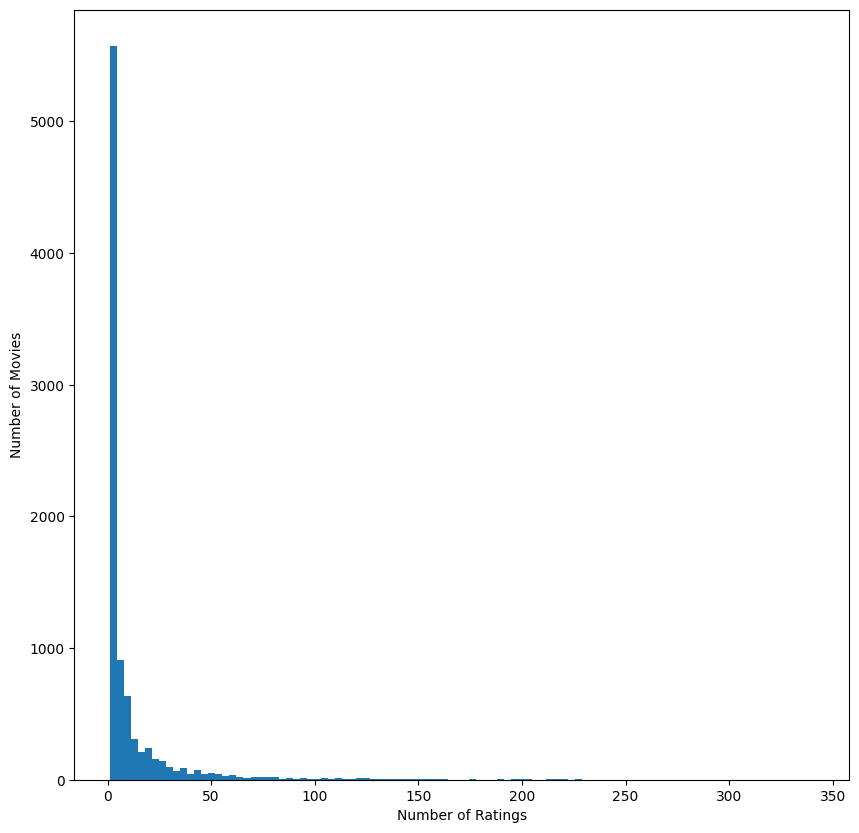

In [12]:
# 영화별 평점 매긴 것 시각화
plt.figure(figsize=(10, 10))
plt.hist(movie_rating_count, bins=100)
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

- 시각화 결과 매우 심한 long-tailed 분포다.
- 즉, 대부분의 영화가 평점을 받아 본 횟수가 적다.

In [13]:
print("10개 이상의 평점을 받은 영화 수:", movie_rating_count[movie_rating_count >= 10].shape[0])
print("100개 이상의 평점을 받은 영화 수:", movie_rating_count[movie_rating_count >= 100].shape[0])

10개 이상의 평점을 받은 영화 수: 2245
100개 이상의 평점을 받은 영화 수: 151


In [14]:
# 영화 별로 평점을 매긴 횟수와 평균 평점 집계
movie_rating_mean = rating_df.groupby("movieId")["rating"].agg(["count", "mean"])
# column 이름을 더 명확하게
movie_rating_mean = movie_rating_mean.rename(columns={"count": "num_ratings", "mean": "rating_mean"})
movie_rating_mean.head()

,num_ratings,rating_mean
movieId,,
1,247,3.872470
2,107,3.401869
3,59,3.161017
4,13,2.384615
5,56,3.267857


<Axes: >

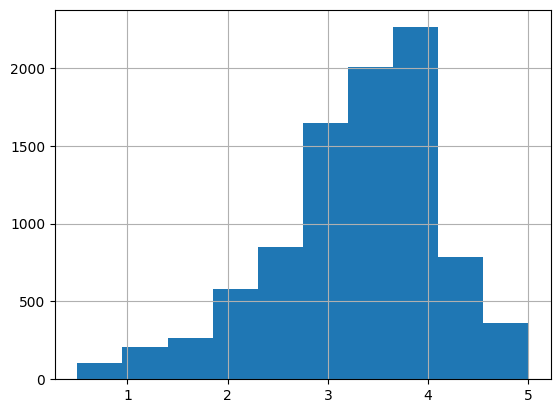

In [15]:
# 평균 점수 분포 시각화
movie_rating_mean["rating_mean"].hist()

- 영화의 평균 평점이 거의 3점 중반 ~ 4점까지로 분포하고 있다.

### 데이터 전처리
- 필요한 데이터는 userId, movieId, ratings
- movieId 로 영화 이름 찾아볼 수 있는 DataFrame

In [16]:
# 영화 id 만 뽑기
movie_ids = rating_df["movieId"].unique()
movie_ids = movie_ids.astype(str)  # 메타 데이터의 id 는 object type
movie_ids

array(['31', '1029', '1061', ..., '129', '4736', '6425'],
      shape=(9066,), dtype='<U21')

In [17]:
# 영화 id 로 title 가져올 수 있는 DataFrame 만들기
movie_title_df = movie_metadata_df[movie_metadata_df["id"].isin(movie_ids)]
movie_title_df = movie_title_df[["id", "original_title"]]  # 필요한 column 만
movie_title_df["id"] = movie_title_df["id"].astype(int)
movie_title_df = movie_title_df.sort_values("id").set_index("id")

print("movie title 의 shape:", movie_title_df.shape)
movie_title_df.head()

movie title 의 shape: (2831, 1)


,original_title
id,
2,Ariel
3,Varjoja paratiisissa
5,Four Rooms
6,Judgment Night
11,Star Wars


In [18]:
# 영화 평점 DataFrame 에서 필요한 column 만 뽑기
movie_ratings = rating_df[["userId", "movieId", "rating"]]
movie_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


## 메모리 기반의 협업 필터링

## 잠재요인 기반의 협업 필터링